In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#from keras.callbacks import EarlyS
from keras.callbacks import EarlyStopping

In [4]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [5]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [6]:
import tensorflow as tf
class Config:
    au = "/kaggle/input/5000-images-authentic-tampered/data_5000/authentic_5000"
    train = "/kaggle/input/5000-images-authentic-tampered/data_5000/tampered_5000"
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 32
    lr = 1e-3
    name = 'xception'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [7]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [8]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

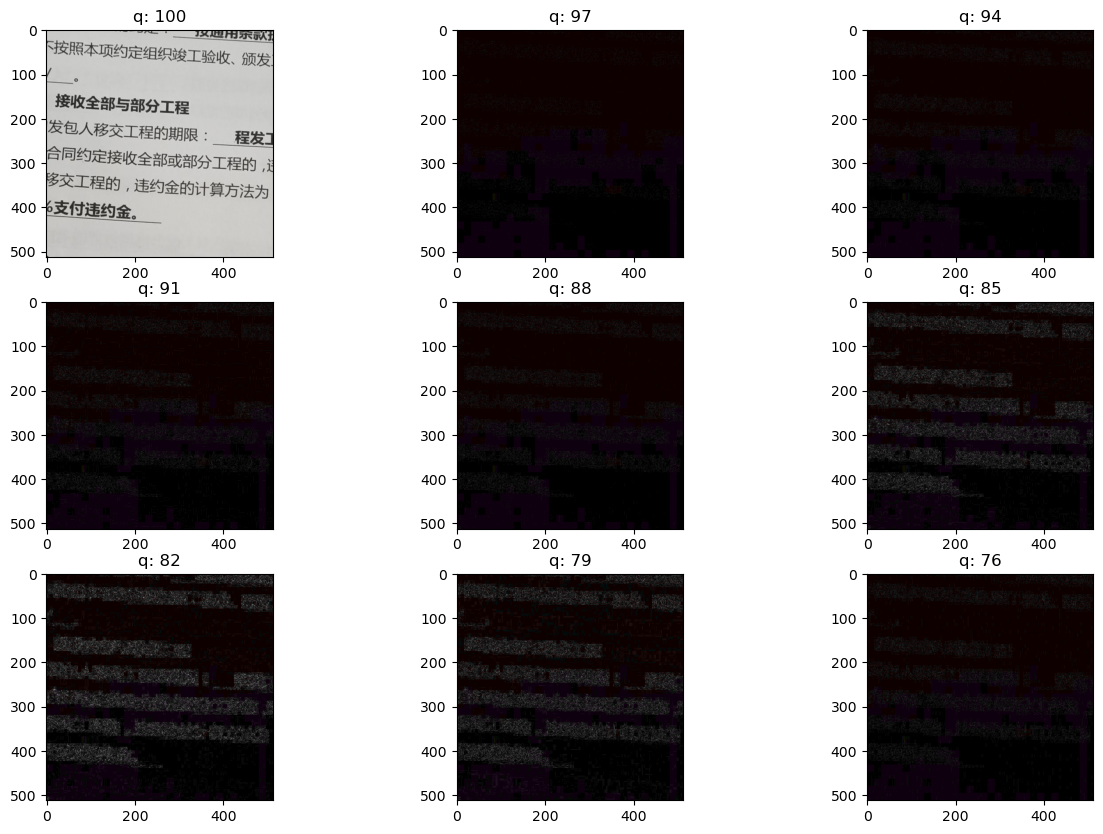

In [9]:
import cv2
from os.path import join, exists, isdir
from pathlib import Path
import random
p = join(Config.train)
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

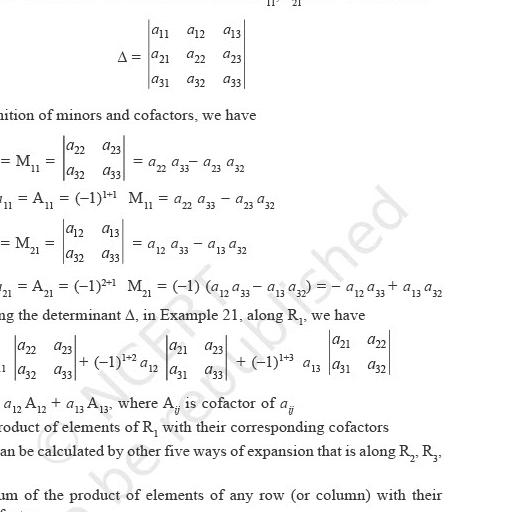

In [10]:
au_image_path = '/kaggle/input/5000-images-authentic-tampered/data_5000/authentic_5000/a10_1711010585017-4023bed8-d4e0-4088-baaa-0f7cf82ef680_10.jpg'
Image.open(au_image_path)

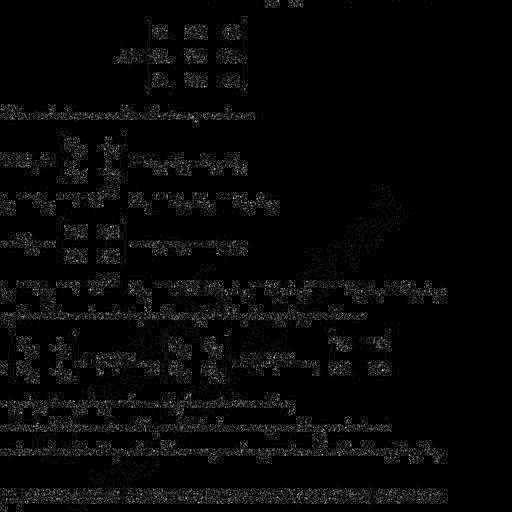

In [11]:
convert_to_ela_image(au_image_path, 91)

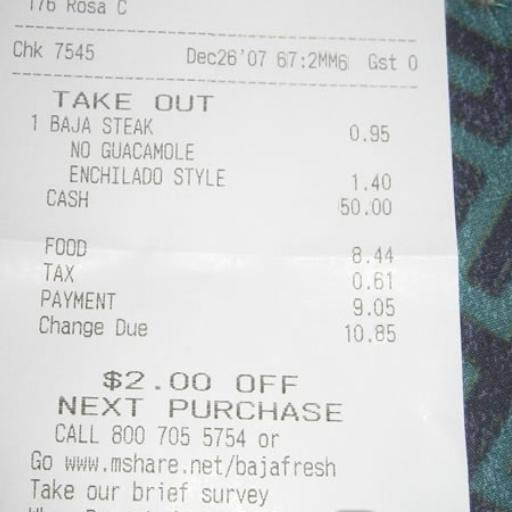

In [12]:
tamp_image_path = '/kaggle/input/5000-images-authentic-tampered/data_5000/tampered_5000/a100032.jpg'
Image.open(tamp_image_path)

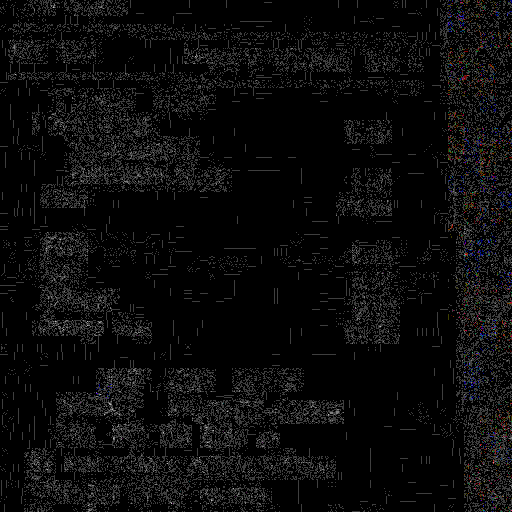

In [13]:
convert_to_ela_image(tamp_image_path, 91)

In [32]:
image_size = (128, 128)

In [33]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 91).resize(image_size)).flatten() / 255.0

In [34]:
X = [] # ELA converted images
Y = [] # 0 for tampered, 1 for real

In [35]:
import random
path = '/kaggle/input/5000-images-authentic-tampered/data_5000/authentic_5000'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
5000 5000


In [36]:
path = '/kaggle/input/5000-images-authentic-tampered/data_5000/tampered_5000'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
10000 10000


In [37]:
import numpy as np
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [38]:
X_t, X_test, Y_t, Y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_t, Y_t, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print("Test images\t\t", len(X_test), len(Y_test))
print("Train images\t\t", len(X_train), len(Y_train))
print("Validation images\t", len(X_val), len(Y_val))

Test images		 1000 1000
Train images		 7200 7200
Validation images	 1800 1800


In [39]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [40]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

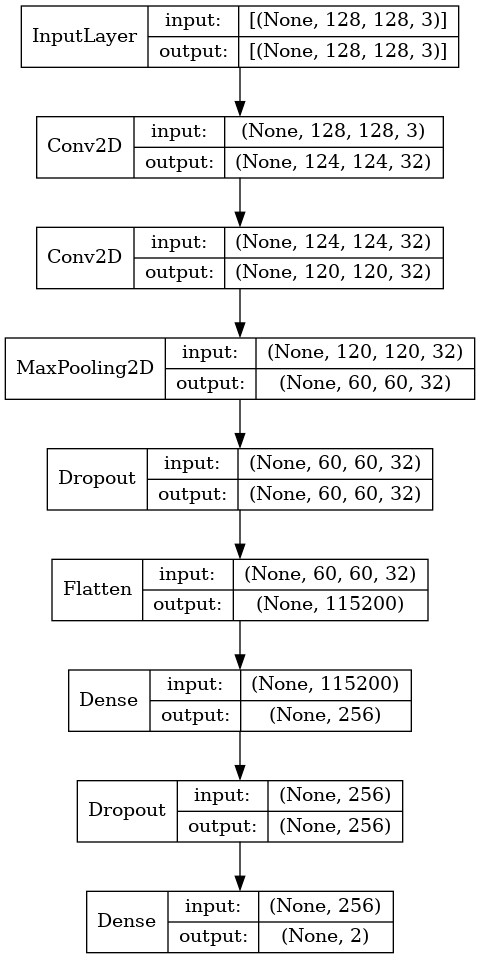

In [41]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_layer_names=False,
expand_nested=True
)

In [42]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [43]:
epochs = 24
batch_size = 32

In [44]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs)

In [45]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [46]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
x_train2 = np.array(X_train, copy=True) 
y_train2 = np.array(Y_train, copy=True) 

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split = 0.2
    )


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

datagen.fit(X_train)

print(type(X_train))

#earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')

validation_generator = datagen.flow(x_train2, y_train2, batch_size=32, subset='validation')
train_generator = datagen.flow(x_train2, y_train2,batch_size=32, subset='training')


# # fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_generator, epochs=epochs, validation_data = (X_val,Y_val), verbose = 1,callbacks = [early_stopping])

<class 'numpy.ndarray'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/24


2024-03-28 04:56:30.672379: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


180/180 [==============================] - 39s 130ms/step - loss: 0.6192 - accuracy: 0.8903 - val_loss: 1.2309 - val_accuracy: 0.4939
Epoch 2/24
180/180 [==============================] - 23s 126ms/step - loss: 0.1485 - accuracy: 0.9491 - val_loss: 1.6121 - val_accuracy: 0.4939
Epoch 3/24
180/180 [==============================] - 23s 125ms/step - loss: 0.1558 - accuracy: 0.9486 - val_loss: 2.0431 - val_accuracy: 0.4939
Epoch 4/24
180/180 [==============================] - 23s 128ms/step - loss: 0.1140 - accuracy: 0.9637 - val_loss: 2.9896 - val_accuracy: 0.4939
Epoch 5/24
180/180 [==============================] - 23s 125ms/step - loss: 0.1052 - accuracy: 0.9658 - val_loss: 1.8510 - val_accuracy: 0.4939
Epoch 6/24
180/180 [==============================] - 22s 125ms/step - loss: 0.0658 - accuracy: 0.9793 - val_loss: 1.7067 - val_accuracy: 0.4939
Epoch 7/24
180/180 [==============================] - 23s 125ms/step - loss: 0.0580 - accuracy: 0.9780 - val_loss: 1.7564 - val_accuracy: 0.4

In [47]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [48]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/24
  1/225 [..............................] - ETA: 2:40 - loss: 1.7769 - accuracy: 0.4688

2024-03-28 05:07:02.984332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 10s 43ms/step - loss: 0.4130 - accuracy: 0.8281 - val_loss: 0.1363 - val_accuracy: 0.9511
Epoch 2/24
225/225 [==============================] - 9s 38ms/step - loss: 0.1366 - accuracy: 0.9517 - val_loss: 0.1106 - val_accuracy: 0.9572
Epoch 3/24
225/225 [==============================] - 9s 38ms/step - loss: 0.1008 - accuracy: 0.9665 - val_loss: 0.0926 - val_accuracy: 0.9661
Epoch 4/24
225/225 [==============================] - 9s 38ms/step - loss: 0.0758 - accuracy: 0.9732 - val_loss: 0.0856 - val_accuracy: 0.9672
Epoch 5/24
225/225 [==============================] - 9s 38ms/step - loss: 0.0628 - accuracy: 0.9789 - val_loss: 0.0790 - val_accuracy: 0.9694
Epoch 6/24
225/225 [==============================] - 9s 38ms/step - loss: 0.0506 - accuracy: 0.9840 - val_loss: 0.0771 - val_accuracy: 0.9689
Epoch 7/24
225/225 [==============================] - 9s 38ms/step - loss: 0.0409 - accuracy: 0.9881 - val_loss: 0.0687 - val_accuracy: 0.9733
Epoch 8/2

In [49]:
model.save('model1.h5')

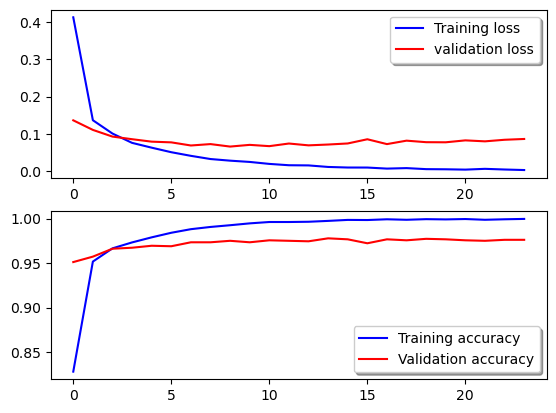

In [50]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

## COnfusion matrix for validation data --> using this, the model is trained

57/57 [==============================] - 1s 9ms/step


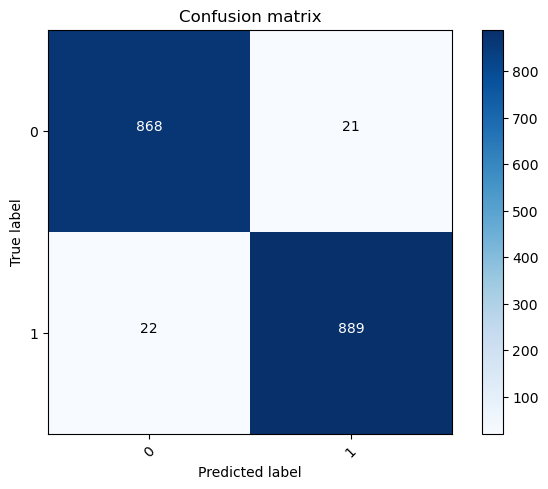

In [52]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

## COnfusion Matrix for test data --> previously unseen by the model

32/32 [==============================] - 0s 8ms/step


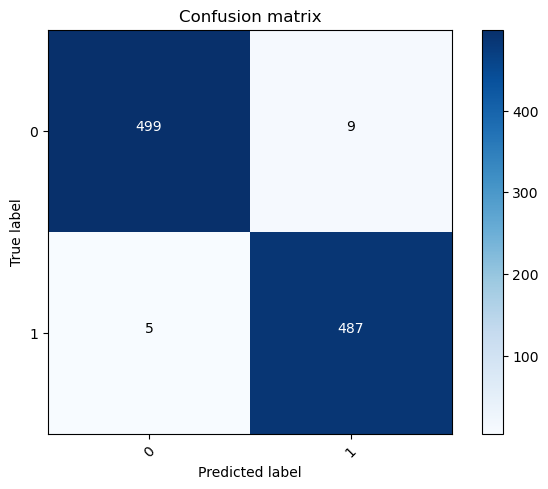

In [53]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [54]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Compute accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(Y_true, Y_pred_classes)
print("Precision:", precision)
print("-----------------------------------------------------")


# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes))


Accuracy: 0.986
Precision: 0.9818548387096774
-----------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       508
           1       0.98      0.99      0.99       492

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



# Testing individual images

In [55]:
class_names = ['tampered', 'real']

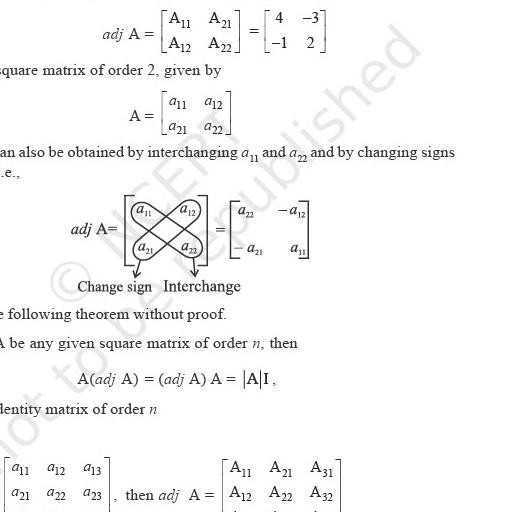

In [56]:
real_image_path = '/kaggle/input/5000-images-authentic-tampered/data_5000/authentic_5000/a10_1711010585017-4023bed8-d4e0-4088-baaa-0f7cf82ef680_13.jpg'
Image.open(real_image_path)+

In [57]:
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 116ms/step
Class: real Confidence: 100.00


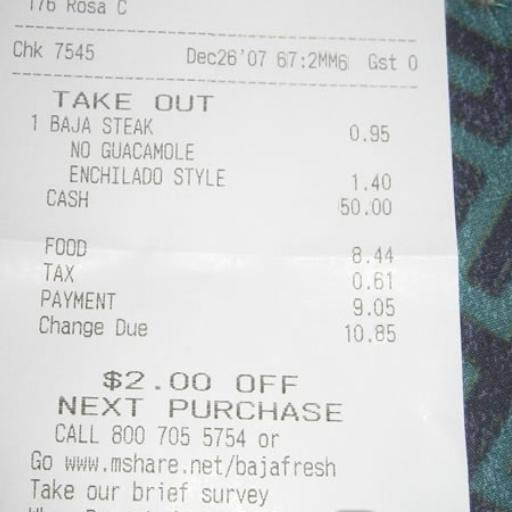

In [58]:
tamp_image_path = '/kaggle/input/5000-images-authentic-tampered/data_5000/tampered_5000/a100032.jpg'
Image.open(tamp_image_path)

In [59]:
image = prepare_image(
    tamp_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 23ms/step
Class: tampered Confidence: 100.00


<br>

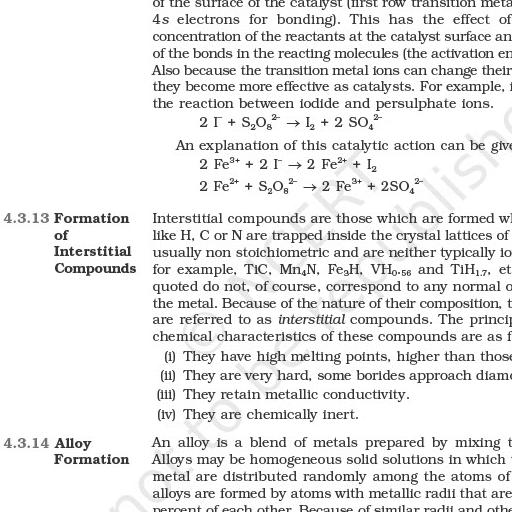

In [60]:
image_path1 = '/kaggle/input/5000-images-authentic-tampered/data_5000/authentic_5000/a10_1711011989317-a77f632f-336d-401d-a211-1572501ab0ed_16.jpg'
Image.open(image_path1)

In [61]:
image = prepare_image(image_path1)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 100.00


In [62]:
print(y_pred_class) # 1--> authentic, 0--> tampered

1


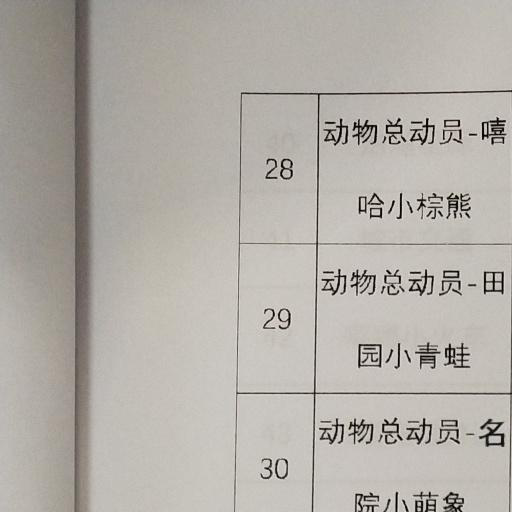

In [63]:
image_path2 = '/kaggle/input/5000-images-authentic-tampered/data_5000/tampered_5000/a10066.jpg'
Image.open(image_path2)

In [64]:
image = prepare_image(image_path2)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 20ms/step
Class: tampered Confidence: 100.00


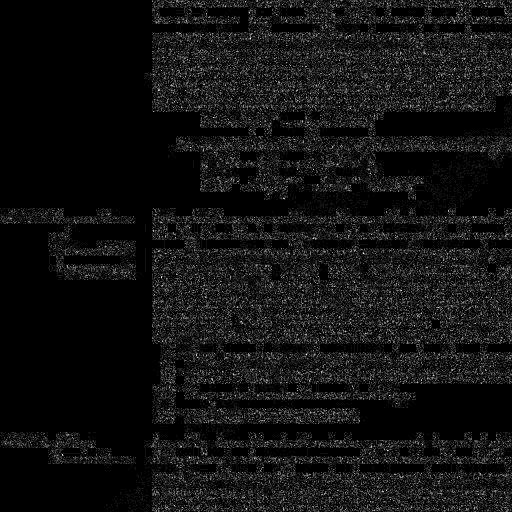

In [65]:
convert_to_ela_image(image_path1, 91)

In [66]:
print(y_pred_class) # 1--> authentic, 0--> tampered

0


In [67]:
def find_manipulated_region(ela, threshold=50):
    mask = np.array(ela) > threshold

    # Find the bounding box of the masked region
    if np.any(mask):
        coords = np.argwhere(mask)
        return coords
    else:
        return None

In [68]:
def make_pixels_white(img, white_coords):
    width, height = img.size
    black_img = Image.new('RGB', (width, height), color='black')
    img_arr = np.array(img)
    black_arr = np.array(black_img)
    for coord in white_coords:
        x, y, z = coord
        black_arr[x,y,:] = [255,255,255]
    mask = np.all(black_arr == [255,255,255], axis=-1)
    img_arr[mask] = [255,255,255]
    new_img = Image.fromarray(img_arr)
    return new_img

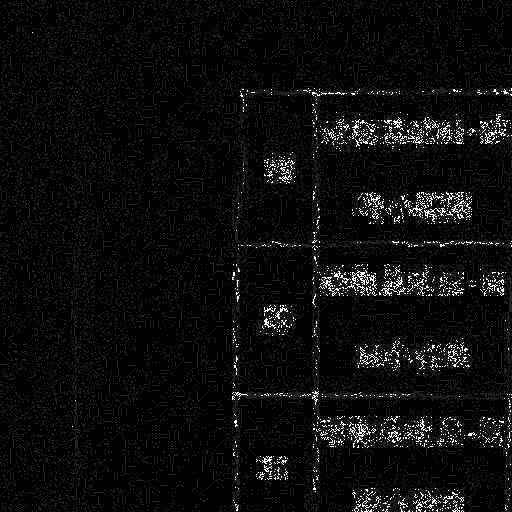

In [69]:
if y_pred_class==0:
    ela=convert_to_ela_image(image_path2,91)
    coords=find_manipulated_region(ela)
    modify_boundary=make_pixels_white(ela,coords)
    display(modify_boundary)